# NLP-LAB Exercise 01 by Jonas Weinz
## links:

* Article: https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/
    * corresponding code: https://github.com/kjam/random_hackery/blob/master/Attempting%20to%20detect%20fake%20news.ipynb

* Tutorial on Datacamp: https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

* liar dataset paper: https://www.cs.ucsb.edu/~william/papers/acl2017.pdf
    * dataset: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

## Dependencies for this Notebook:
* library [rdflib](https://github.com/RDFLib/rdflib)
    * install: `pip3 install rdflib`


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import itertools
import sklearn.utils as sku
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from pprint import pprint as pp
import os

## Tools used later

In [3]:
def plot_confusion_matrix(cm, classes,
                          title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    fig_1, ax_1 = plt.subplots()
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix for: ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Generate/Download Datasets we are working on

* running bash script to download all needed data and store it into the `data` subfolder

In [4]:
%%bash
./Task_2_gen_data.sh

checking whether unzip is installed
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Latest sources and executables are at ftp://ftp.info-zip.org/pub/infozip/ ;
see ftp://ftp.info-zip.org/pub/infozip/UnZip.html for other sites.

Compiled with gcc 6.3.0 20170415 for Unix (Linux ELF).

UnZip special compilation options:
        ACORN_FTYPE_NFS
        COPYRIGHT_CLEAN (PKZIP 0.9x unreducing method not supported)
        SET_DIR_ATTRIB
        SYMLINKS (symbolic links supported, if RTL and file system permit)
        TIMESTAMP
        UNIXBACKUP
        USE_EF_UT_TIME
        USE_UNSHRINK (PKZIP/Zip 1.x unshrinking method supported)
        USE_DEFLATE64 (PKZIP 4.x Deflate64(tm) supported)
        UNICODE_SUPPORT [wide-chars, char coding: UTF-8] (handle UTF-8 paths)
        LARGE_FILE_SUPPORT (large files over 2 GiB supported)
        ZIP64_SUPPORT (archives using Zip64 for large files supported)
        USE_BZIP2 (PKZIP 4.6+, using bzip2 lib version 1.0.6, 6-Sept-2010)
     

## Read in fake news table

In [5]:
df_1 = pd.read_csv('data/fake_or_real_news.csv').set_index('Unnamed: 0')

* display first 10 entries

In [6]:
display(df_1.shape)
display(df_1[:10])

(6335, 3)

title  \
Unnamed: 0                                                      
8476                             You Can Smell Hillary’s Fear   
10294       Watch The Exact Moment Paul Ryan Committed Pol...   
3608              Kerry to go to Paris in gesture of sympathy   
10142       Bernie supporters on Twitter erupt in anger ag...   
875          The Battle of New York: Why This Primary Matters   
6903                                              Tehran, USA   
7341        Girl Horrified At What She Watches Boyfriend D...   
95                          ‘Britain’s Schindler’ Dies at 106   
4869        Fact check: Trump and Clinton at the 'commande...   
2909        Iran reportedly makes new push for uranium con...   

                                                         text label  
Unnamed: 0                                                           
8476        Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
10294       Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
3608        U.S. Secretary of State John F. Kerry said Mon...  REAL  
10142       — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
875         It's primary day in New York and front-runners...  REAL  
6903          \nI’m not an immigrant, but my grandparents ...  FAKE  
7341        Share This Baylee Luciani (left), Screenshot o...  FAKE  
95          A Czech stockbroker who saved more than 650 Je...  REAL  
4869        Hillary Clinton and Donald Trump made some ina...  REAL  
2909        Iranian negotiators reportedly have made a las...  REAL

* create test dataset

In [7]:
def create_training_and_test_set(dset, cutoff=0.7):
    shuffled = sku.shuffle(dset) # shuffle dataset
    y = shuffled.label
    shuffled = shuffled.drop('label', axis=1)['text']
    size = int(cutoff * shuffled.shape[0])
    return shuffled[:size], y[:size], shuffled[size:], y[size:]
    

In [8]:
X,y, Xt,yt = create_training_and_test_set(df_1)

In [9]:
#X2,y2, Xt2,yt2 = train_test_split(df_1['text'],df_1.label,test_size=0.3)

In [10]:
X

Unnamed: 0
5476     Share on Twitter \nFor Robin Roberts, losing h...
1223     Jeb Bush’s resignation from the presidential r...
8179      Does The U.S. Government Really Know Who Hack...
6457     Print \n[Ed. – Now teaching the gospel of raci...
2236     Video of a confrontation between a news photog...
7451     Tony Blair helpfully describes Remain voters a...
7548     Tweet Home » Headlines » World News » It’s A S...
2409     President Obama's top health official testifie...
3918     And it looks like that time is nigh. Clinton i...
7698     ‹ › Arnaldo Rodgers is a trained and educated ...
1461     Ben Carson pitched a tax plan with numbers tha...
3850     President Barack Obama has officially hit the ...
3168     From Coca-Cola to Microsoft, companies that ga...
5738     Trending Articles: Trending Articles: ‘Chairma...
3655     The horrific attack in Orlando, Florida, showe...
4656     With less than two weeks to go, the race for t...
6823     Email Print This is WHY Comey wrote 

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X)
count_test = count_vectorizer.transform(Xt)

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X)
tfidf_test = tfidf_vectorizer.transform(Xt)

In [13]:
pp(count_vectorizer.get_feature_names()[0:10])
pp(count_vectorizer.get_feature_names()[-10:])


['00',
 '000',
 '0000',
 '00000031',
 '000035',
 '00006',
 '0002',
 '000ft',
 '000x',
 '001']
['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']


In [14]:
pp(tfidf_vectorizer.get_feature_names()[:10])
pp(tfidf_vectorizer.get_feature_names()[-10:])

['00',
 '000',
 '0000',
 '00000031',
 '000035',
 '00006',
 '0002',
 '000ft',
 '000x',
 '001']
['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']


In [15]:
#count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
#tfidf_df = pd.DataFrame(count_train.A, columns=tfidf_vectorizer.get_feature_names())
#diff = set(count_df.columns) - set(tfidf_df.columns)
#pp(count_df.equals(tfidf_df))

'score: 0.8574434508153603'
Confusion matrix, without normalization


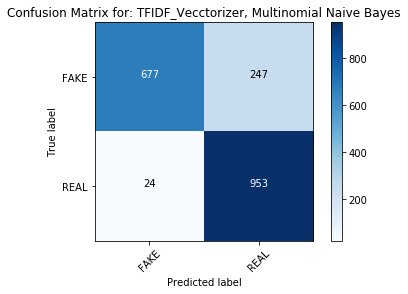

In [16]:
clf = MultinomialNB()
clf.fit(tfidf_train, y)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(yt, pred)
pp("score: " + str(score))
cm = metrics.confusion_matrix(yt, pred, labels=["FAKE", "REAL"])
plot_confusion_matrix(cm, classes=["FAKE", "REAL"], title= "TFIDF_Vecctorizer, Multinomial Naive Bayes")

'score: 0.8916359810625987'
Confusion matrix, without normalization


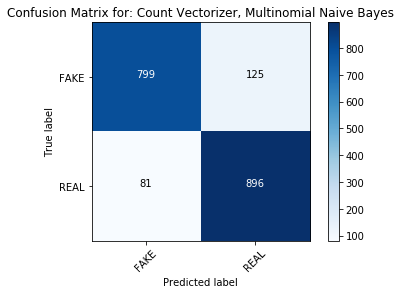

In [17]:
clf = MultinomialNB()
clf.fit(count_train, y)
pred = clf.predict(count_test)
score = metrics.accuracy_score(yt, pred)
pp("score: " + str(score))
cm = metrics.confusion_matrix(yt, pred, labels=["FAKE", "REAL"])
plot_confusion_matrix(cm, classes=["FAKE", "REAL"], title= "Count Vectorizer, Multinomial Naive Bayes")

* comparing to PassiveAggresiveClassifier

/home/jonas/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.933
Confusion matrix, without normalization


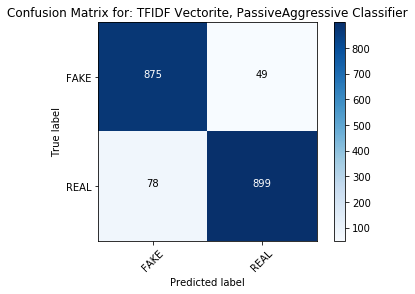

In [18]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

linear_clf.fit(tfidf_train, y)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(yt, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(yt, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'], title= "TFIDF Vectorite, PassiveAggressive Classifier")

In [19]:
clf = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(yt, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

/home/jonas/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.87849
Alpha: 0.10 Score: 0.91215
Alpha: 0.20 Score: 0.90637
Alpha: 0.30 Score: 0.90005
Alpha: 0.40 Score: 0.89216
Alpha: 0.50 Score: 0.88795
Alpha: 0.60 Score: 0.88217
Alpha: 0.70 Score: 0.87217
Alpha: 0.80 Score: 0.86902
Alpha: 0.90 Score: 0.86113


* try to get most important features

In [20]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)



FAKE -4.986418446992282 2016
FAKE -4.031739222213152 october
FAKE -3.2450737607438835 hillary
FAKE -3.163046832110649 article
FAKE -3.0797196307769865 november
FAKE -2.9126602525203786 election
FAKE -2.7767455973246777 share
FAKE -2.5799080044431215 establishment
FAKE -2.5391003972219663 wikileaks
FAKE -2.5124769239037335 mosul
FAKE -2.5044337732634636 source
FAKE -2.376392497005016 oct
FAKE -2.323456790625324 print
FAKE -2.296605039295202 advertisement
FAKE -2.1765893008482884 podesta
FAKE -2.1254730787507397 corporate
FAKE -2.1186888933652006 comments
FAKE -2.0814842675932406 russia
FAKE -1.9405914175220103 watch
FAKE -1.8706195854259284 war
FAKE -1.867386639102956 posted
FAKE -1.8056831543703649 com
FAKE -1.8054376409136181 navigation
FAKE -1.7877228165152776 26
FAKE -1.7685005227604957 stated
FAKE -1.7402325468939963 dakota
FAKE -1.7271994282637921 jewish
FAKE -1.7263968946984054 ayotte
FAKE -1.7200570381137112 donald
FAKE -1.6535827908878833 pipeline

REAL 5.015301141104506 said
R

* another way to perform this

In [21]:
feature_names = tfidf_vectorizer.get_feature_names()
### Most real
display(sorted(zip(linear_clf.coef_[0], feature_names), reverse=True)[:20])
### Most fake
display(sorted(zip(linear_clf.coef_[0], feature_names))[:20])

[(5.015301141104506, 'said'),
 (3.0775436014367448, 'says'),
 (2.6550720089727093, 'say'),
 (2.5730784312333856, 'gop'),
 (2.537624697551335, 'debate'),
 (2.37704059797269, 'islamic'),
 (2.3533175343115773, 'friday'),
 (2.324743477167939, 'jobs'),
 (2.285274612684968, 'conservative'),
 (2.2415729758446785, 'marriage'),
 (2.2145701146991454, 'rush'),
 (2.1909548260953593, 'tuesday'),
 (2.164804177946772, 'continue'),
 (2.1533786245547075, 'fox'),
 (2.134959398360091, 'cruz'),
 (1.9490044497446428, 'manafort'),
 (1.9042544756391377, 'candidates'),
 (1.8970529284348485, 'convention'),
 (1.8966333613592279, 'parties'),
 (1.8807450356106956, 'recounts')]

[(-4.986418446992282, '2016'),
 (-4.031739222213152, 'october'),
 (-3.2450737607438835, 'hillary'),
 (-3.163046832110649, 'article'),
 (-3.0797196307769865, 'november'),
 (-2.9126602525203786, 'election'),
 (-2.7767455973246777, 'share'),
 (-2.5799080044431215, 'establishment'),
 (-2.5391003972219663, 'wikileaks'),
 (-2.5124769239037335, 'mosul'),
 (-2.5044337732634636, 'source'),
 (-2.376392497005016, 'oct'),
 (-2.323456790625324, 'print'),
 (-2.296605039295202, 'advertisement'),
 (-2.1765893008482884, 'podesta'),
 (-2.1254730787507397, 'corporate'),
 (-2.1186888933652006, 'comments'),
 (-2.0814842675932406, 'russia'),
 (-1.9405914175220103, 'watch'),
 (-1.8706195854259284, 'war')]

* analyse token weights

In [22]:
tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))
tokens_with_weights[:20]

[('00', -10.806288039676962),
 ('000', -8.4757571521028),
 ('0000', -11.31983755527844),
 ('00000031', -11.306788627092281),
 ('000035', -11.375220169061265),
 ('00006', -11.285092170704173),
 ('0002', -11.375220169061265),
 ('000ft', -11.020175960097573),
 ('000x', -11.346623773737496),
 ('001', -11.224561919245287),
 ('0011', -11.375220169061265),
 ('002', -11.253666274798343),
 ('003', -11.226941303318013),
 ('004', -11.303970982653903),
 ('005', -11.375220169061265),
 ('00684', -11.375220169061265),
 ('006s', -11.375220169061265),
 ('007', -11.375220169061265),
 ('007s', -11.375220169061265),
 ('008', -11.270210919871277)]

----
## Building an own classifier for the 'pants on fire' dataset
